[*Reference*1](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)<br>
[*Reference*2](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)<br>
[*Reference*3](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)<br>
[**KERAS**](https://keras.io/)

# Word2Vec

Input - Text Corpus<br>
Output - set of words<br>
A well-trained set of word vectors will place similar words close to each other in that space

![model image](https://miro.medium.com/max/1728/1*HmmFCZpKk3i4EvMYZ855tg.png)

Two main training algorithms
- CBOW -> using context to predict a target word
- Skip-gram -> using a word to predict a target context

### Mounting the drive to use dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Dataset IMDB/IMDB Dataset.csv")

In [4]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
sentiment = df['sentiment'].values.tolist()
for i in range(len(sentiment)):
    if sentiment[i]=='positive':
        sentiment[i] = 1
    else:
        sentiment[i] = 0
type(sentiment[0])

int

In [7]:
df['sentiment'] = sentiment
df.dtypes

review       object
sentiment     int64
dtype: object

In [8]:
df.shape

(50000, 2)

In [9]:
df['review'].values.tolist()[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [14]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import re #regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [15]:
lemmatizer = WordNetLemmatizer()
reviews = list()
stop_words = set(stopwords.words('english'))
lines = df['review'].values.tolist()

for line in lines:
    
    #first we remove the tags as once we split them to words its hard to remove them
    line = re.sub(r'<[^>]+>',' ',line) #remove html tags
    
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    
    #remove punctuaution
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    #filter out stop words
    words = [w for w in words if w not in stop_words]
    reviews.append(words)

In [21]:
EMBED_DIM = 100

In [16]:
len(reviews)

50000

In [18]:
sum_len = sum([len(s) for s in reviews])
max_len = max([len(s) for s in reviews])
avg_len = int(sum_len/len(reviews))
print(f'summation - {sum_len}, maximum - {max_len}, average - {avg_len}')

summation - 5904336, maximum - 1420, average - 118


In [25]:
import gensim
#train word2vec model
model = gensim.models.Word2Vec(sentences=reviews,size=EMBED_DIM,window=2,workers=4,min_count=1)
#see about these parameters
words = list(model.wv.vocab)
print(f'Vocabulary size: {len(words)}')

Vocabulary size: 134132


In [26]:
model.wv.most_similar('horrible')

[('terrible', 0.9239498972892761),
 ('awful', 0.8739575743675232),
 ('dreadful', 0.8490228652954102),
 ('horrendous', 0.8415277600288391),
 ('atrocious', 0.8237575888633728),
 ('lousy', 0.8180842399597168),
 ('horrid', 0.8118277788162231),
 ('pathetic', 0.8062487244606018),
 ('appalling', 0.7934110760688782),
 ('abysmal', 0.7763357162475586)]

In [27]:
#save model
filename = 'imdb_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename,binary=False)

### Use Pre-trained Embedding

In [11]:
import os
import numpy as np

embeddings_index = {}
f = open('/content/drive/MyDrive/Dataset IMDB/imdb_embedding_word2vec.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()
print(f'loaded {len(embeddings_index)} word vectors')

loaded 134133 word vectors


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [19]:
#vectorize the text samples into 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(reviews)
sequences = tokenizer_obj.texts_to_sequences(reviews)


#pad sequences
word_index = tokenizer_obj.word_index
print(f'Found {len(word_index)} unique tokens.')


review_pad = pad_sequences(sequences, maxlen=max_len,padding='post')
sentiment = df['sentiment'].values
print('Shape of review tensor:',review_pad.shape)
print('Shape of sentiment tensor:',sentiment.shape)

Found 134132 unique tokens.
Shape of review tensor: (50000, 1420)
Shape of sentiment tensor: (50000,)


In [22]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBED_DIM))

for word, i in word_index.items():
    # if i>num_words:
    #     continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
embedding_matrix.shape

(134133, 100)

In [24]:
print(num_words)

134133


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

#define model
model = Sequential()
embedding_layer = Embedding(num_words,EMBED_DIM,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1420, 100)         13413300  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,426,197
Trainable params: 12,897
Non-trainable params: 13,413,300
_________________________________________________________________


In [36]:
VALIDATION_SPLIT = 0.3 #70-30 train test split
indices = np.arange(review_pad.shape[0])

np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

In [37]:
print(f'Shape of X_train_pad tensor: {X_train_pad.shape}')
print(f'Shape of y_train tensor: {y_train.shape}')
print(f'Shape of X_test_pad tensor: {X_test_pad.shape}')
print(f'Shape of y_test tensor: {y_test.shape}')

Shape of X_train_pad tensor: (35000, 1420)
Shape of y_train tensor: (35000,)
Shape of X_test_pad tensor: (15000, 1420)
Shape of y_test tensor: (15000,)


In [38]:
print('Train....')
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad,y_test),verbose=1)

Train....
Epoch 1/25
274/274 [==============================] - 23s 76ms/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 2/25
274/274 [==============================] - 20s 75ms/step - loss: 0.6932 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 3/25
274/274 [==============================] - 20s 74ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 4/25
274/274 [==============================] - 20s 74ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 5/25
274/274 [==============================] - 20s 74ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 6/25
274/274 [==============================] - 20s 75ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 7/25
274/274 [==============================] - 20s 73ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val

In [40]:
def plotLearningCurve(history,epochs):
    import matplotlib.pyplot as plt

    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history['accuracy'])
    plt.plot(epoch_range,history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(epoch_range,history['loss'])
    plt.plot(epoch_range,history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()

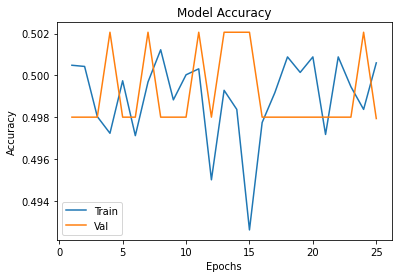

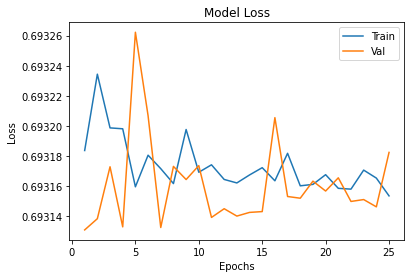

In [47]:
plotLearningCurve(history.history,len(history.epoch))